In [1]:
import numpy as np
import pandas as pd
import time
from scipy.linalg import solve, kron
from scipy import stats
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Kailman filter calibration

In [ ]:
# ================================
# 1. initial settings
# ================================
wsdata = './'
#wsdata = '/Users/taka/Library/CloudStorage/GoogleDrive-ktaka8128@gmail.com/My Drive/Princeton/Spring2025/COS513/Final/'
inputfile = 'DNSinput_JPY_long_add40.csv'
calibrationstart = 0
calibrationend = 1161

outputfile = 'DNSoutput_JPY_long_calibration_202203_add40.csv'
LSCoutputfile = 'DNSoutput_JPY_long_LSC_202203_add40.csv'
outdetail = True
outputdetailfile = 'DNSoutput_JPY_long_calibration_detail_202203_add40.csv'

# initial parameters
para0 = np.concatenate((
    np.array([0.28]),
    np.array([-3.46944695e-17,  7.50000000e-02,
        1.80000000e-02,  7.60000000e-02,  9.30000000e-02,  6.40000000e-02,
       -3.46944695e-18,  6.00000000e-02,  1.20000000e-01,]),
    np.array([9.93753000e-01,
        9.92190000e-01,  9.97835000e-01]),
    np.array([2.37000000e+00, -2.29500000e+00,
       -2.65000000e+00]),
    np.array([8.40000000e-02, -8.10000000e-02,  2.80000000e-02,
       -1.19000000e-01, -1.10000000e-01,  1.36000000e-01])
))
#np.repeat(0.050, 9)


# parameter update scale
paraStep = np.concatenate((
    np.array([-20]),
    np.repeat(-3, 6),
    np.repeat(-2, 3),
    np.repeat(-4, 3),
    np.repeat(-2, 3),
    np.repeat(-3, 6)
))
# Nelson–Siegel girds
grid = np.array([1, 5, 7, 10, 15, 20, 25, 30, 40])
gridn = len(grid)
lambdastep = np.arange(0.26, 0.32 + 0.01, 0.01)
maxstepn = 10000
tstep = 52

# ================================
# 2. utility functions
# ================================

def lyapunov(N, phi, Q):
    I = np.eye(N * N)
    K_mat = np.kron(phi, phi)
    vecP = np.linalg.solve(I - K_mat, Q.flatten())
    return vecP.reshape(N, N)

def Nelson_Siegel_factor_loadings(l, m):
    m = np.array(m)
    column1 = np.ones(len(m))
    column2 = (1 - np.exp(-l * m)) / (l * m)
    column3 = column2 - np.exp(-l * m)
    lambmat = np.column_stack((column1, column2, column3))
    return lambmat

def Kfilter(logLik, N, T, Y, Z, a_t, P_t, H, a_tt, P_tt, v2, v1, phi, mu, Q, prev, M, Yf, lik):
    for t in range(T):
        v = Y[t, :] - Z @ a_t[t, :]
        F = Z @ P_t[t, :, :] @ Z.T + H
        detF = np.linalg.det(F)
        if detF <= 1e-30 or np.isnan(detF) or np.isinf(detF):
            logLik = -10**15
            break
        else:
            F_inv = np.linalg.inv(F)
            logLik = logLik - 0.5 * (np.log(detF) + v.T @ F_inv @ v)
        a_tt[t, :] = a_t[t, :] + P_t[t, :, :] @ Z.T @ F_inv @ v
        P_tt[t, :, :] = P_t[t, :, :] - P_t[t, :, :] @ Z.T @ F_inv @ Z @ P_t[t, :, :]
        v1[t, :] = Z @ a_tt[t, :]
        v2[t, :] = Y[t, :] - Z @ a_tt[t, :]
        a_t[t+1, :] = phi @ a_tt[t, :] + (np.eye(N) - phi) @ mu.flatten()
        P_t[t+1, :, :] = phi @ P_tt[t, :, :] @ phi.T + Q

    if prev:
        t0 = T - 1
        for m_i in range(1, M+1):
            Yf[t0 + m_i, :] = Z @ a_t[t0 + m_i, :]
            a_tt[t0 + m_i, :] = a_t[t0 + m_i, :]
            P_tt[t0 + m_i, :, :] = P_t[t0 + m_i, :, :]
            a_t[t0 + m_i + 1, :] = phi @ a_tt[t0 + m_i, :] + (np.eye(N) - phi) @ mu.flatten()
            P_t[t0 + m_i + 1, :, :] = phi @ P_tt[t0 + m_i, :, :] @ phi.T + Q

    if lik:
        return -logLik
    else:
        return {'a_tt': a_tt, 'a_t': a_t, 'P_tt': P_tt, 'P_t': P_t, 'v2': v2, 'v1': v1, 'Yf': Yf}

def kalman(para, Y, lik, prev, ahead, grid):
    l = para[0]
    m = grid
    mlen = len(m)
    M = ahead
    if prev:
        T = Y.shape[0]
        Yf = Y.copy()
        Yf[T-M:T, :] = np.nan
        Y = Y[:T-M, :]
        T = Y.shape[0]
    else:
        T = Y.shape[0]
        Yf = None
    
    pars = {}
    W = Y.shape[1]
    N = 3
    pars['mu'] = np.full((N, 1), np.nan)
    pars['phi'] = np.eye(N)
    pars['H'] = np.eye(W)
    pars['Q'] = np.eye(N)
    
    # Loading matrix
    pars['Z'] = Nelson_Siegel_factor_loadings(l, m)
    
    for i in range(mlen):
        pars['H'][i, i] = para[1 + i]
    H = pars['H'] ** 2
    
    # VAR(1) coefficient matrix
    pars['phi'][0, 0] = para[mlen+1]
    pars['phi'][0, 1] = 0
    pars['phi'][0, 2] = 0
    pars['phi'][1, 0] = 0
    pars['phi'][1, 1] = para[mlen+2]
    pars['phi'][1, 2] = 0
    pars['phi'][2, 0] = 0
    pars['phi'][2, 1] = 0
    pars['phi'][2, 2] = para[mlen+3]
    
    pars['mu'][0, 0] = para[mlen+4]
    pars['mu'][1, 0] = para[mlen+5]
    pars['mu'][2, 0] = para[mlen+6]
    
    pars['Q'][0, 0] = para[mlen+7]
    pars['Q'][1, 0] = para[mlen+8]
    pars['Q'][1, 1] = para[mlen+9]
    pars['Q'][2, 0] = para[mlen+10]
    pars['Q'][2, 1] = para[mlen+11]
    pars['Q'][2, 2] = para[mlen+12]
    
    Q = pars['Q'] @ pars['Q'].T
    
    # Initialize matrices
    if prev:
        a_t = np.full((T+M, N), np.nan)
        a_tt = np.full((T, N), np.nan)
        P_t = np.full((T+M, N, N), np.nan)
        P_tt = np.full((T, N, N), np.nan)
    else:
        a_t = np.full((T+1, N), np.nan)
        a_tt = np.full((T, N), np.nan)
        P_t = np.full((T+1, N, N), np.nan)
        P_tt = np.full((T, N, N), np.nan)
    v1 = np.full((T, W), np.nan)
    v2 = np.full((T, W), np.nan)
    
    if prev and Yf is None:
        Yf = Y.copy()
    
    a_t[0, :] = pars['mu'].flatten()
    P_t[0, :, :] = lyapunov(N, pars['phi'], Q)
    
    logLik = -0.5 * T * W * math.log(2 * math.pi)
    
    out = Kfilter(logLik, N, T, Y, pars['Z'], a_t, P_t, H, a_tt, P_tt, v2, v1, pars['phi'], pars['mu'], Q, prev, M, Yf, lik)
    return out

# ================================
# 3. load data
# ================================
data0 = pd.read_csv(wsdata + inputfile, header=0, index_col=0, encoding='cp1252')
data0.index = pd.to_datetime(data0.index)
data = data0.iloc[calibrationstart:calibrationend, :].values * 100

# ================================
# 4. calibration
# ================================
resultsall = []
results = []

for k in lambdastep:
    para0[0] = k
    print(k)
    startTime = time.time()
    
    NoP = len(para0)
    lik0 = kalman(para=para0, Y=data, lik=True, prev=False, ahead=1, grid=grid)
    
    paraNext = para0.copy()
    likNext = lik0
    
    for j in range(1, maxstepn+1):
        if j % 1000 == 0:
            print(j)
        i = j % NoP  # i in 0,...,NoP-1
        paraP = paraNext.copy()
        paraM = paraNext.copy()
        paraP[i] = paraNext[i] + 10.0**(paraStep[i])
        paraM[i] = paraNext[i] - 10.0**(paraStep[i])
        
        likP = kalman(para=paraP, Y=data, lik=True, prev=False, ahead=1, grid=grid)
        likN = likNext
        likM = kalman(para=paraM, Y=data, lik=True, prev=False, ahead=1, grid=grid)
        
        if likP < likN:
            paraNext = paraP.copy()
            likNext = likP
        elif likM < likN:
            paraNext = paraM.copy()
            likNext = likM
        
        resultsall.append(np.concatenate(([j], paraNext, [likNext])))
        
        if j > NoP+1 and resultsall[-1][gridn+15-1] == resultsall[-NoP][gridn+15-1]: #abs(resultsall[-1][gridn+15-1] - resultsall[-NoP][gridn+15-1]) < 0.00001
            break
    
    results.append(np.concatenate(([j], paraNext, [likNext])))
    endTime = time.time()
    print(endTime - startTime)

resultsall = np.array(resultsall)
results = np.array(results)
min_index = np.argmin(results[:, gridn+15-1])
minresults = results[min_index, :]
pd.DataFrame(minresults.reshape(1,-1)).to_csv(wsdata + outputfile, index=False)

if outdetail:
    pd.DataFrame(resultsall).to_csv(wsdata + outputdetailfile, index=False)

paratest = minresults[1:(gridn+15-1)]
LSCresult = kalman(para=paratest, Y=data, lik=False, prev=False, ahead=1, grid=grid)
pd.DataFrame(LSCresult['a_tt']).to_csv(wsdata + LSCoutputfile, index=False)


0.26
65.42434000968933
0.27
50.79525089263916
0.28
23.208251953125
0.29000000000000004
104.82864999771118
0.30000000000000004
58.68385624885559
0.31000000000000005
44.08446192741394
0.32000000000000006
42.01943802833557
0.33000000000000007
97.21937489509583


In [7]:
minresults

array([ 2.56000000e+02,  3.00000000e-01, -3.46944695e-17,  7.50000000e-02,
        1.90000000e-02,  6.70000000e-02,  9.20000000e-02,  6.50000000e-02,
       -3.46944695e-18,  7.00000000e-02,  1.20000000e-01,  9.93753000e-01,
        9.92190000e-01,  9.97935000e-01,  2.34000000e+00, -2.26500000e+00,
       -2.54000000e+00,  8.40000000e-02, -8.10000000e-02,  2.80000000e-02,
       -1.19000000e-01, -1.09000000e-01,  1.35000000e-01, -1.43428676e+04])

## ICS risk yields

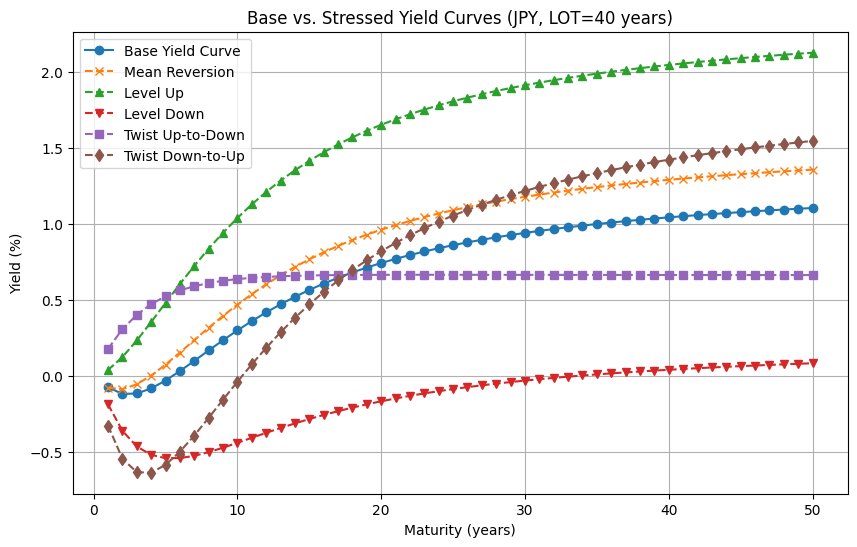


[LSC Parameters]
lambda: 0.3000
mu: [ 0.0234  -0.02265 -0.0254 ]
K: [0.324844 0.40612  0.10738 ]
LSC Parameters: [ 0.01349726 -0.01309311 -0.02384254]
level_up_scenario: [-4.25440377e-03  4.42633389e-03 -6.69949141e-05]
twist_scenario: [-0.00267709  0.00253143  0.01193346]


In [8]:
# ================
# 1. utility functions 
# ================
def ns_loadings(tau, lam):
    level = 1.0
    slope = (1 - np.exp(-lam * tau)) / (lam * tau) if tau > 1e-12 else 1.0
    curvature = slope - np.exp(-lam * tau)
    return np.array([level, slope, curvature])

maturities = [str(i) for i in range(1, 51)]
maturities_float = np.array([float(m) for m in maturities])
#maturities = ['1','2','3','4','5','6','7','8','9','10','15','20','25','30','40']
#maturities_float = np.array([float(m) for m in maturities])


def lyapunov(N, phi, Q):
    I = np.eye(N * N)
    K_mat = np.kron(phi, phi)
    vecP = np.linalg.solve(I - K_mat, Q.flatten())
    return vecP.reshape(N, N)

def Nelson_Siegel_factor_loadings(l, m):
    m = np.array(m)
    column1 = np.ones(len(m))
    column2 = (1 - np.exp(-l * m)) / (l * m)
    column3 = column2 - np.exp(-l * m)
    return np.column_stack((column1, column2, column3))

beta_calibrated = LSCresult['a_tt'][-1, :]/100  # 最終日の状態

LOT = 40
lambda_val = minresults[1]
K_est = (np.ones(3) - minresults[11:14])*tstep
mu_est = minresults[14:17]/100

def compute_yield_curve(beta, lam, tau_array):
    return np.array([beta @ ns_loadings(t, lam) for t in tau_array])
base_yields = compute_yield_curve(beta_calibrated, lambda_val, maturities_float)

# ================
# 2. compute yield curves for ICS risk calculation
# ================
# Mean Reversion シナリオ
Delta = (1 - np.exp(-K_est)) * (mu_est - beta_calibrated)
shift_curve_mr = np.array([np.dot(Delta, ns_loadings(t, lambda_val)) for t in maturities_float])
stressed_yields_mr = base_yields + shift_curve_mr

def build_M(K, Sigma):
    SS = Sigma @ Sigma.T
    K_diag = np.array(K)
    out = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            kij = K_diag[i] + K_diag[j]
            out[i, j] = (1 - np.exp(-kij)) / kij if kij > 1e-12 else 0.0
    SSout = SS * out
    M = np.linalg.cholesky(SSout)
    return M

def build_N_diag(LOT, a, b):
    return np.diag([LOT, a, b])

def sum_slope_curve(lam, LOT):
    s = 0.0
    for tau in range(1, LOT+1):
        s += ns_loadings(tau, lam)[1]
    return s

def sum_curvature_curve(lam, LOT):
    s = 0.0
    for tau in range(1, LOT+1):
        s += ns_loadings(tau, lam)[2]
    return s

def calc_theta(lam, LOT, M_, e1, e2):
    sum_h1 = 0.0
    sum_h2 = 0.0
    for tau in range(1, LOT+1):
        load = ns_loadings(tau, lam)
        h1 = load @ (M_ @ e1)
        h2 = load @ (M_ @ e2)
        sum_h1 += h1
        sum_h2 += h2
    if abs(sum_h1) < 1e-12:
        return np.pi/2 if sum_h2 > 0 else -np.pi/2
    return np.arctan(sum_h2/sum_h1)

def level_up_scenario(K, Sigma, lam, LOT):
    M_ = build_M(K, Sigma)
    a_ = sum_slope_curve(lam, LOT)
    b_ = sum_curvature_curve(lam, LOT)
    N_ = build_N_diag(LOT, a_, b_)
    NM = N_ @ M_
    NtN = NM @ NM.T
    eigvals, eigvecs = np.linalg.eig(NtN)
    idx = np.argsort(eigvals)[::-1]
    e1 = eigvecs[:, idx[0]]
    e2 = eigvecs[:, idx[1]]
    theta_ = calc_theta(lam, LOT, M_, e1, e2)
    Me1 = M_ @ e1
    Me2 = M_ @ e2
    sl_vec = np.cos(theta_) * Me1 + np.sin(theta_) * Me2
    load_LOT = ns_loadings(LOT, lam)
    shift_LOT = np.dot(sl_vec, load_LOT)
    s_ = 1.0 if shift_LOT >= 0 else -1.0
    return sl_vec, s_, theta_

Q = np.zeros((3, 3))
Q[0, 0] = minresults[17]*np.sqrt(tstep)/100
Q[1, 0] = minresults[18]*np.sqrt(tstep)/100
Q[1, 1] = minresults[19]*np.sqrt(tstep)/100
Q[2, 0] = minresults[20]*np.sqrt(tstep)/100
Q[2, 1] = minresults[21]*np.sqrt(tstep)/100
Q[2, 2] = minresults[22]*np.sqrt(tstep)/100
M_est = build_M(K_est, Q)
sl_vector, s_sign, theta_val = level_up_scenario(K_est, Q, lambda_val, LOT)

n_inv = norm.ppf(0.995)

tau_list = maturities_float
shift_curve_level = []
for tau in tau_list:
    load = ns_loadings(tau, lambda_val)
    shift = np.dot(sl_vector, load)
    shift_curve_level.append(s_sign * n_inv * shift)
shift_curve_level = np.array(shift_curve_level)
stressed_yields_level_up = base_yields +  shift_curve_level
stressed_yields_level_down = base_yields - shift_curve_level

def twist_scenario_parameters(K, Sigma, lam, LOT):
    # Level Upシナリオと同様に M, N, 固有値分解を行う
    M_ = build_M(K, Sigma)
    a_ = sum_slope_curve(lam, LOT)
    b_ = sum_curvature_curve(lam, LOT)
    N_ = build_N_diag(LOT, a_, b_)
    NM = N_ @ M_
    NtN = NM @ NM.T
    eigvals, eigvecs = np.linalg.eig(NtN)
    idx = np.argsort(eigvals)[::-1]
    e1 = eigvecs[:, idx[0]]
    e2 = eigvecs[:, idx[1]]
    theta_ = calc_theta(lam, LOT, M_, e1, e2)
    # twist_vector の推計： Level Up の式とは異なり、符号が逆転する
    twist_vector = np.cos(theta_)*(M_ @ e2) - np.sin(theta_)*(M_ @ e1)
    return twist_vector, theta_

twist_vector, theta_twist = twist_scenario_parameters(K_est, Q, lambda_val, LOT)
shift_curve_twist = np.array([np.dot(twist_vector, ns_loadings(t, lambda_val)) for t in tau_list])
shift_curve_twist *= n_inv
stressed_yields_twist_up_to_down = base_yields +  shift_curve_twist
stressed_yields_twist_down_to_up = base_yields -  shift_curve_twist


plt.figure(figsize=(10,6))
plt.plot(maturities_float, base_yields*100, label="Base Yield Curve", marker='o')
plt.plot(maturities_float, stressed_yields_mr*100, label="Mean Reversion", marker='x', linestyle="--")
plt.plot(maturities_float, stressed_yields_level_up*100, label="Level Up", marker='^', linestyle="--")
plt.plot(maturities_float, stressed_yields_level_down*100, label="Level Down", marker='v', linestyle="--")
plt.plot(maturities_float, stressed_yields_twist_up_to_down*100, label="Twist Up-to-Down", marker='s', linestyle="--")
plt.plot(maturities_float, stressed_yields_twist_down_to_up*100, label="Twist Down-to-Up", marker='d', linestyle="--")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("Base vs. Stressed Yield Curves (JPY, LOT=40 years)")
plt.legend()
plt.grid(True)
plt.show()

# print lsc parameters
print("\n[LSC Parameters]")
print(f"lambda: {lambda_val:.4f}")
print(f"mu: {mu_est}")
print(f"K: {K_est}")
print(f"LSC Parameters: {beta_calibrated}")
print(f"level_up_scenario: {sl_vector}")
print(f"twist_scenario: {twist_vector}")



In [9]:
# aggregate yield curves for risk calculation to 1 dataframe
yield_curves = pd.DataFrame({
    'Maturity': maturities_float,
    'Base Yield': base_yields,
    'Mean Reversion': stressed_yields_mr,
    'Level Up': stressed_yields_level_up,
    'Level Down': stressed_yields_level_down,
    'Twist Up-to-Down': stressed_yields_twist_up_to_down,
    'Twist Down-to-Up': stressed_yields_twist_down_to_up
})
yield_curves.columns = ['Maturity'] + ['Base Yield', 'Mean Reversion', 'Level Up', 'Level Down', 'Twist Up-to-Down', 'Twist Down-to-Up']
yield_curves
yield_curves.to_csv(wsdata + 'DNS40_yield_curves_for_ICSrisk_202203.csv', index=False)

In [10]:
yc=[]
for i in range(LSCresult['a_tt'].shape[0]):
    lsc_para = LSCresult['a_tt'][i, :]/100
    yc.append(compute_yield_curve(lsc_para, lambda_val, maturities_float))
data1 = data0.iloc[calibrationstart:calibrationend, :].copy()
yc_df = pd.DataFrame(yc, index=data1.index, columns=maturities)
yc_df.to_csv(wsdata + 'DNS40_calibrated_yield_curves_202203.csv', index=True)
